In [40]:
import numpy as np

def create_embedding_matrix(word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open('180/model.txt', encoding='utf-8') as f:
        for line in f:
            word_, *vector = line.split()
            word = word_.split('_')[0]
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)

    return embedding_matrix

In [2]:
with open('180/model.txt', encoding='utf-8') as f:
    i = 0
    for line in f:
        word, *vector = line.split()
        i = i + 1 
    print(i)

189194


In [3]:
import pymorphy2
import nltk
import string
from nltk.corpus import stopwords


morph = pymorphy2.MorphAnalyzer()

stop_words = stopwords.words('russian')
stop_words.extend(['«', '»', '–', '...', '“', '”', '—', '!',
                   '@', '№', ':', ',', '.', '?', ':', '(', ')'])
stop_words = set(stop_words)

def normalize_review(review):
    """

    :param review:
    :param morph:
    :return:
    """

    tokens = nltk.word_tokenize(review)
    normalized_tokens = []
    # normalized_review = ''
    for token in tokens:
        token = morph.parse(token)[0].normal_form
        if token not in stop_words and token not in string.punctuation:
            normalized_tokens.append(token.lower())

    return " ".join(normalized_tokens)

In [29]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()

train_texts = []
with open('ALL_reviews.txt', encoding='utf-8') as f:
    for line in f:
        train_texts.append(normalize_review(line))

test_texts = []
with open('all_my_reviews.txt', encoding='utf-8') as f:
    for line in f:
        test_texts.append(normalize_review(line))

        
tokenizer.fit_on_texts(train_texts)
X_train = tokenizer.texts_to_sequences(train_texts)
X_test = tokenizer.texts_to_sequences(test_texts)

import pandas
excel_file = pandas.read_excel('Отзывы кино.xlsx', 0)

# Оценки для отзывов
Y_train = []

for i, row in excel_file.iterrows():
    if (row['title'] != 'Криминальное чтиво' and
        row['title'] != 'Маленькая Мисс Счастье' and
        row['title'] != 'Амели'):
        Y_train.append(row['label'])
        
Y_test = []

for i, row in excel_file.iterrows():
    if (row['title'] == 'Криминальное чтиво' or
        row['title'] == 'Маленькая Мисс Счастье' or
        row['title'] == 'Амели'):
        Y_test.append(row['label'])
        


In [30]:
print(len(X_train))
print(len(X_test))
print(len(tokenizer.word_index.items()))

print(len(Y_train))
print(len(Y_test))


610
90
18656
610
90


In [33]:
# Максимальное количество слов в самом длинном отзыве
lens = [len(x) for x in X_train]
max_words = max(lens)
print(max_words)

print('Максимальное количество слов в самом длинном отзыве: {} слов'.format(max_words))

total_unique_words = len(tokenizer.word_counts)
print('Всего уникальных слов в словаре: {}'.format(total_unique_words))

maxSequenceLength = max_words


1608
Максимальное количество слов в самом длинном отзыве: 1608 слов
Всего уникальных слов в словаре: 18656


In [34]:
vocab_size = total_unique_words

In [39]:
from keras.preprocessing.sequence import pad_sequences
import keras
import numpy as np
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Y_train)
y_train = encoder.transform(Y_train)
y_test = encoder.transform(Y_test)

num_classes = np.max(y_train) + 1
print('Количество категорий для классификации: {}'.format(num_classes))


x_train = pad_sequences(X_train, maxlen=maxSequenceLength)
x_test = pad_sequences(X_test, maxlen=maxSequenceLength)
print('Размерность X_train:', x_train.shape)
print('Размерность X_test:', x_test.shape)

print(u'Преобразуем категории в матрицу двоичных чисел '
      u'(для использования categorical_crossentropy)')

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

Количество категорий для классификации: 3
Размерность X_train: (610, 1608)
Размерность X_test: (90, 1608)
Преобразуем категории в матрицу двоичных чисел (для использования categorical_crossentropy)
y_train shape: (610, 3)
y_test shape: (90, 3)


In [45]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM

# максимальное количество слов для анализа
max_features = vocab_size + 1


embedding_dim = 300
embedding_matrix = create_embedding_matrix(tokenizer.word_index, embedding_dim)

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=300, input_length=maxSequenceLength, weights=[embedding_matrix], trainable=False))
model.add(LSTM(300, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print (model.summary())


Собираем модель...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1608, 300)         5597100   
_________________________________________________________________
lstm_2 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 903       
Total params: 6,319,203
Trainable params: 722,103
Non-trainable params: 5,597,100
_________________________________________________________________
None


In [46]:
batch_size = 32
epochs = 3

print(u'Тренируем модель...')
history = model.fit(
    x_train, 
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    verbose=1
)


Тренируем модель...
Train on 610 samples, validate on 90 samples
Epoch 1/3
610/610 [==============================] - 364s 596ms/step - loss: 0.6304 - accuracy: 0.6563 - val_loss: 0.5970 - val_accuracy: 0.6741
Epoch 2/3
610/610 [==============================] - 399s 655ms/step - loss: 0.5320 - accuracy: 0.7410 - val_loss: 0.6063 - val_accuracy: 0.6444
Epoch 3/3
610/610 [==============================] - 424s 696ms/step - loss: 0.4580 - accuracy: 0.7896 - val_loss: 0.6130 - val_accuracy: 0.6963


In [67]:
loss, accuracy = model.evaluate(x_train, y_train, batch_size=batch_size, verbose=1)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
print("Testing Accuracy:  {:.4f}".format(accuracy))

610/610 [==============================] - 75s 124ms/step
Training Accuracy: 0.8366
90/90 [==============================] - 11s 127ms/step
Testing Accuracy:  0.6963


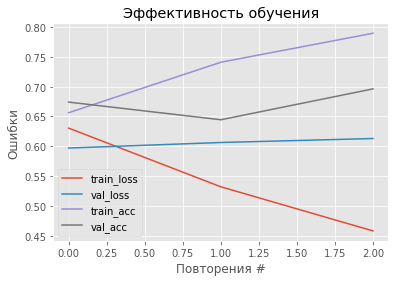

In [64]:
# Посмотрим на эффективность обучения
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Эффективность обучения")
plt.xlabel("Повторения #")
plt.ylabel("Ошибки")
plt.legend(loc="lower left")


In [62]:
text_labels = encoder.classes_ 

pred_classes = []

for i in range(90):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    pred_classes.append(predicted_label)
    

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
    
print(Y_test)
print(pred_classes)
print("LSTM Accuracy Score -> ",accuracy_score(pred_classes, Y_test)*100)
print(precision_recall_fscore_support(Y_test, pred_classes, average='weighted'))


[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[-1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, 0, 1, 1, 1, 1, -1, 0, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, -1, 1, 0, 0, -1, -1, -1, -1, -1, 0, -1, 1, 1, 1, 1, -1, 1, -1, 0, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 0]
LSTM Accuracy Score ->  53.333333333333336
(0.4908536585365854, 0.5333333333333333, 0.4751667902149741, None)
